In [1]:
# try random policy on the kitty
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import sys
from collections import defaultdict

import random
from datetime import datetime

# number of episodes 
n_epi = 200
alpha = 0.5
epsilon = 0.01
n_steps = 200

act_dict = {
    "LEFT": 0,
    "DOWN": 1,
    "RIGHT": 2,
    "UP": 3,
    "PAUSE": 4,
}
run_type = "lifelong"

In [2]:
def train_plot(epi_iter, epi_reward, direction, n_epi = n_epi, run_type = run_type):
    now = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

    fig, axs = plt.subplots(2)
    axs[0].set_title(f'{n_epi} Episodes and iterations, alpha = {alpha}, epsilon = {epsilon}')
    axs[0].set_xlabel('Number of episodes')
    axs[0].set_ylabel('Number of iterations')
    axs[1].set_title(f'{n_epi} Episodes and reward')
    axs[1].set_xlabel('Number of episodes')
    axs[1].set_ylabel('Reward')
    axs[0].plot(epi_iter)
    axs[1].plot(epi_reward)
    fig.tight_layout()

    plt.savefig(f'Plot/{n_dim}x{n_dim}_{n_epi}_Episodes and iterations_{direction}_{run_type}_method_2.png',\
                bbox_inches='tight')

In [3]:
desc_file = open("map_14_14_v1.txt", "r") 
  
desc_content = desc_file.read() 

# for the env that elf is the main agent and head to "to"
desc = desc_content.split("\n") 
# for the env that kitty is the main agent and head to "to"
desc_k = desc_content.split("\n") 
desc = [d for d in desc if d!='']
desc_k = [d for d in desc_k if d!='']

desc_file.close() 
n_dim = len(desc[0])

# location of kitty, cat food, pet home, elf, starting point, goal point
K_loc, C_loc, P_loc, E_loc, S_loc, G_loc = list(), list(), list(), list(), list(), list()

for i in range(len(desc)):
    if 'K' in desc[i]:
        
        K_loc.extend([i, desc[i].index('K')])
    if 'C' in desc[i]:
        C_loc.extend([i, desc[i].index('C')])
    if 'S' in desc[i]:
        S_loc.extend([i, desc[i].index('S')])
    if 'G' in desc[i]:
        G_loc.extend([i, desc[i].index('G')])

K_loc_from, E_loc_from = list(), list() # 
# kitty location is the same as pet home location initially
P_loc.extend([K_loc[0], K_loc[1]])
K_loc_from.extend([C_loc[0], C_loc[1]])
# elf location is the same as starting point location initially
E_loc.extend([S_loc[0], S_loc[1]])
E_loc_from.extend([G_loc[0], G_loc[1]])

# locate holes 
H_loc_list = list()
for i in range(len(desc)):
    for d in range(len(desc[i])):
        if desc[i][d] == 'H':
            H_loc_list.append([i, d])
            
# Update desc_k for the env where kitty is the main agent
# use P and C as starting point and goal to train kitty's Q-table
# S and G are replaced by K and C
desc_k[S_loc[0]] = desc_k[S_loc[0]][:S_loc[1]]+'K'+desc_k[S_loc[0]][S_loc[1]+1:]
desc_k[G_loc[0]] = desc_k[G_loc[0]][:G_loc[1]]+'C'+desc_k[G_loc[0]][G_loc[1]+1:]
desc_k[P_loc[0]] = desc_k[P_loc[0]][:P_loc[1]]+'S'+desc_k[P_loc[0]][P_loc[1]+1:]
desc_k[C_loc[0]] = desc_k[C_loc[0]][:C_loc[1]]+'G'+desc_k[C_loc[0]][C_loc[1]+1:]


desc_from, desc_k_from = list(), list()
# for the env that elf is the main agent and head to "from"
desc_from.extend(desc) 
desc_from[S_loc[0]] = desc_from[S_loc[0]][:S_loc[1]]+'G'+desc_from[S_loc[0]][S_loc[1]+1:]
desc_from[G_loc[0]] = desc_from[G_loc[0]][:G_loc[1]]+'S'+desc_from[G_loc[0]][G_loc[1]+1:]
desc_from[P_loc[0]] = desc_from[P_loc[0]][:P_loc[1]]+'C'+desc_from[P_loc[0]][P_loc[1]+1:]
desc_from[C_loc[0]] = desc_from[C_loc[0]][:C_loc[1]]+'K'+desc_from[C_loc[0]][C_loc[1]+1:]

# for the env that kitty is the main agent and head to "from"
desc_k_from.extend(desc_k)
desc_k_from[P_loc[0]] = desc_k_from[P_loc[0]][:P_loc[1]]+'G'+desc_k_from[P_loc[0]][P_loc[1]+1:]
desc_k_from[C_loc[0]] = desc_k_from[C_loc[0]][:C_loc[1]]+'S'+desc_k_from[C_loc[0]][C_loc[1]+1:]
desc_k_from[S_loc[0]] = desc_k_from[S_loc[0]][:S_loc[1]]+'C'+desc_k_from[S_loc[0]][S_loc[1]+1:]
desc_k_from[G_loc[0]] = desc_k_from[G_loc[0]][:G_loc[1]]+'K'+desc_k_from[G_loc[0]][G_loc[1]+1:]


In [4]:
def epsilon_greedy(env, epsilon, num_act, Q):
    """
    return a function to compute probability of choosing each action on the given state
    """
    def policy_s(state):
        action_probs = np.full(num_act,epsilon/num_act)
        a = np.argmax(Q[state])
        action_probs[a] += (1-epsilon)
        
        return action_probs
    return policy_s


In [5]:
elf_info = {
    'agent': E_loc, # current location of elf
    'from': S_loc, 
    # if elf is seeking starting point or goal. True for goal
    'if_to' : True,
    'to' : G_loc,
    'holes' : H_loc_list,
    'current_from' : P_loc, # current agent getting trained is kitty and comes from P
    'current_to' : C_loc,
    }

# to train Q-table when elf start from "to" and head to "from"
elf_info_from = {
    'agent': E_loc_from, # current location of elf
    'from': G_loc, 
    # if elf is seeking starting point or goal. True for Starting point
    'if_to' : True,
    'to' : S_loc,
    'holes' : H_loc_list,
    'current_from' : C_loc, # current agent getting trained is kitty and comes from food
    'current_to' : P_loc,
    }

kitty_info = {
    'agent': K_loc, # current location of kitty
    'from': P_loc, 
    # if kitty is seeking food or home. True for food
    'if_to' : True,
    'to' : C_loc,
    'holes' : H_loc_list,
    'current_from' : S_loc, # # current agent getting trained is elf and comes from starting point
    'current_to' : G_loc,
    }

kitty_info_from = {
    'agent': K_loc_from, # current location of kitty
    'from': C_loc, 
    # if kitty is seeking food or home. True for HOME
    'if_to' : True,
    'to' : P_loc,
    'holes' : H_loc_list,
    'current_from' : G_loc, # # current agent getting trained is elf and comes from Goal
    'current_to' : S_loc,
    }

state_dict = {
    "current_from": 'S',
    "current_to": 'G',
    "other_from": 'P',
    "other_to": 'C',
    "other_agent": 'K',
}

In [6]:
def to_original_component(env, other_agent, state_dict = state_dict):
    # in k_env_f: change the grid of elf_info['agent'] to its original value in the map
    # in e_env_g: change the grid of kitty_info['agent'] to its original value in the map
    
    if other_agent['agent'] in other_agent['holes']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'H'
        
    # if the other agent is locating on current agent's from
    elif other_agent['agent'] == other_agent['current_from']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['current_from'].encode('UTF-8')
        
    # if the other agent is locating on current agent's to
    elif other_agent['agent'] == other_agent['current_to']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['current_to'].encode('UTF-8')
        
    elif other_agent['agent'] == other_agent['from']:    
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['other_from'].encode('UTF-8')
        
    elif other_agent['agent'] == other_agent['to']: 
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['other_to'].encode('UTF-8')
        
    else:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'F'
        
    return env, other_agent

In [7]:
def other_agent_move(env, other_agent, num_dim, Q_other_agent):
    
    # if the other agent already arrives at its destination, no need to move the other agent
    if other_agent['agent'] != other_agent['to']:
        env, other_agent = to_original_component(env, other_agent)
        # compute other agent's state
        other_agent_state = other_agent['agent'][0] * num_dim + other_agent['agent'][1] 
        
        # get other agent's action
        other_agent_act = np.argmax(Q_other_agent[other_agent_state])
        
        if other_agent_act == 0: # LEFT
            other_agent['agent'][1] = max(other_agent['agent'][1]-1, 0)
        elif other_agent_act ==1: # DOWN
            other_agent['agent'][0] = min(other_agent['agent'][0]+1, num_dim -1)
        elif other_agent_act == 2: # RIGHT
            other_agent['agent'][1] = min(other_agent['agent'][1]+1, num_dim -1)
        elif other_agent_act ==3: # UP
            other_agent['agent'][0] = max(other_agent['agent'][0]-1, 0)
        
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'K'
    
    return env, other_agent

In [8]:
def other_agent_move_train(env, other_agent, num_dim, Q_other_agent, epsilon = epsilon):
    
    # if the other agent already arrives at its destination, no need to move the other agent
    if other_agent['agent'] != other_agent['to']:
        env, other_agent = to_original_component(env, other_agent)
        
        # compute other agent's state
        other_agent_state = other_agent['agent'][0] * num_dim + other_agent['agent'][1] 
        
        # get other agent's policy
        other_act_policy = epsilon_greedy(env, epsilon, env.action_space.n, Q_other_agent)
        other_act_probs = other_act_policy(other_agent_state)
        
        # get other agent's action
        other_agent_act = np.random.choice(len(other_act_probs), p = other_act_probs)
                
        if other_agent_act == 0: # LEFT
            other_agent['agent'][1] = max(other_agent['agent'][1]-1, 0)
        elif other_agent_act ==1: # DOWN
            other_agent['agent'][0] = min(other_agent['agent'][0]+1, num_dim -1)
        elif other_agent_act == 2: # RIGHT
            other_agent['agent'][1] = min(other_agent['agent'][1]+1, num_dim -1)
        elif other_agent_act ==3: # UP
            other_agent['agent'][0] = max(other_agent['agent'][0]-1, 0)
        
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'K'
    
    return env, other_agent

In [9]:
def Q_learning(kitty, elf, desc, desc_k, num_episodes = n_epi, \
               num_dim= n_dim, discount_factor = 1.0, alpha = alpha, epsilon = epsilon):
    
    # env that the kitty heading for food
    k_env = gym.make('FrozenLake-v1', desc=desc_k, is_slippery=False, render_mode = 'rgb_array')
    # env that elf heading for goal
    e_env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
    # get num of actions
    nA = e_env.action_space.n
    
    Q_kitty = defaultdict(lambda: np.zeros(nA)) # initialize Q-value for kitty
    Q_elf = defaultdict(lambda: np.zeros(nA)) # initialize Q-value for elf

    # initialize policy for kitty and elf
    policy_kitty = epsilon_greedy(k_env, epsilon, nA, Q_kitty)
    policy_elf = epsilon_greedy(e_env, epsilon, nA, Q_elf)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):
        
        print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        
        # env that the kitty heading for food
        k_env = gym.make('FrozenLake-v1', desc=desc_k, is_slippery=False, render_mode = 'rgb_array')
        # env that elf heading for goal
        e_env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
        # initialize kitty's state    
        k_state = k_env.reset()[0]
        # initialize kitty's state    
        e_state = e_env.reset()[0]
        

        num_iter = 1
        num_k_terminate,  num_e_terminate= 0, 0 
       
        while num_k_terminate == 0 or num_e_terminate == 0:
            # print(num_iter, 'iterations')
            if num_k_terminate == 0:
                ######################
                ## Train kitty first##
                ######################
                k_act_probs = policy_kitty(k_state)

                 # randomly choose an action following probability in k_act_probs
                k_action = np.random.choice(len(k_act_probs), p = k_act_probs)
                k_next_state, k_reward, k_terminated, k_truncated, k_info = k_env.step(k_action)

                k_max_next_Q = max(Q_kitty[k_next_state])
                Q_kitty[k_state][k_action] += alpha *(k_reward + discount_factor * k_max_next_Q - \
                                                      Q_kitty[k_state][k_action])

                episode_iterations[i_epi] = num_iter+1
                episode_reward[i_epi] += k_reward

                # update elf's location in kitty's env
                k_env, elf = other_agent_move(k_env, elf, num_dim, Q_elf)
                
                k_state = k_next_state
                
                if k_terminated:
                    num_k_terminate += 1
            
            if num_e_terminate == 0:
                ##################
                ## Train elf now##
                ##################

                # update kitty's location in elf's env
                e_env, kitty = other_agent_move(e_env, kitty, num_dim, Q_kitty)

                e_act_probs = policy_elf(e_state)

                # randomly choose an action following probability in e_act_probs
                e_action = np.random.choice(len(e_act_probs), p = e_act_probs)
                e_next_state, e_reward, e_terminated, e_truncated, e_info = e_env.step(e_action)

                e_max_next_Q = max(Q_elf[e_next_state])
                Q_elf[e_state][e_action] += alpha *(e_reward + discount_factor * e_max_next_Q - \
                                                      Q_elf[e_state][e_action])

                episode_iterations[i_epi] = num_iter+1
                episode_reward[i_epi] += e_reward
                
                e_state = e_next_state

                if e_terminated:
                    num_e_terminate += 1
         
            num_iter +=1
            
        
    return Q_kitty, Q_elf, episode_iterations, episode_reward


# both agent start from "from" and heading to "to"
Q_kitty_to, Q_elf_to, episode_iterations_to, episode_reward_to = Q_learning(kitty = kitty_info, elf = elf_info, \
                                                                   desc = desc, desc_k = desc_k)
# both agent start from "to" and heading to "from" 
Q_kitty_from, Q_elf_from, episode_iterations_from, episode_reward_from = Q_learning(kitty = kitty_info_from,\
                                                                                elf = elf_info_from, \
                                                                                desc = desc_from, desc_k = desc_k_from)

Episode: 200

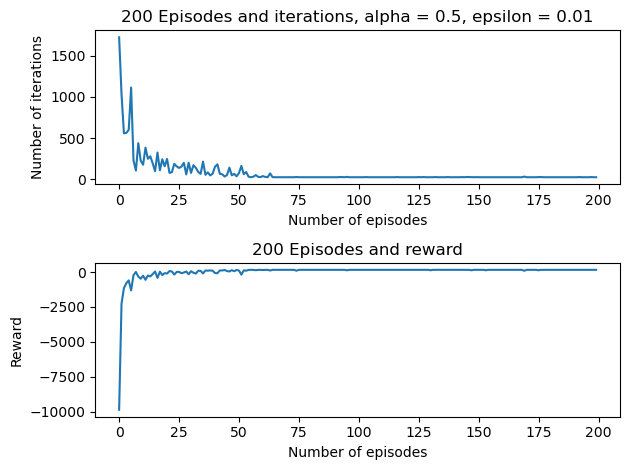

In [10]:
train_plot(episode_iterations_to, episode_reward_to, direction = "to")


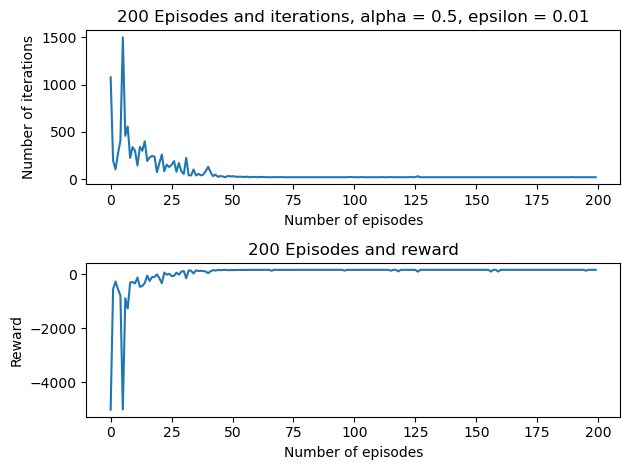

In [11]:
train_plot(episode_iterations_from, episode_reward_from, direction = "from")


In [12]:
def reverse_terminated(st, terminate_val, env, num_dim = n_dim):
    """
    Args: st: S_state or G_state. Change S_state to a destination, then st = True and terminate_val = True
    terminate_val: True or False. The updated value of terminated
    """
    # if next state of a state when taking action a is st,
    # reverse "terminated" at the state when taking action a to True or False
    if (st - num_dim) in env.P.keys(): # the state  which take "DOWN" can reach st
        env_P_val = env.P[st - num_dim][act_dict["DOWN"]][0]
        env.P[st - num_dim][act_dict["DOWN"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st + num_dim) in env.P.keys(): # the state  which take "UP" can reach st
        env_P_val = env.P[st + num_dim][act_dict["UP"]][0]
        env.P[st + num_dim][act_dict["UP"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st -1) in env.P.keys(): # the state  which take "RIGHT" can reach st
        env_P_val = env.P[st -1][act_dict["RIGHT"]][0]
        env.P[st - 1][act_dict["RIGHT"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st +1) in env.P.keys(): # the state  which take "LEFT" can reach st
        env_P_val = env.P[st + 1][act_dict["LEFT"]][0]
        env.P[st + 1][act_dict["LEFT"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    # if next state of st when taking action a is the same as st
    # next state of taking action a on S leads to terminated == terminate_val
    for a in range(env.action_space.n):
        t_p_S = env.P[st][a][0]
        if t_p_S[1] == st: 
            env.P[st][a][0] = (t_p_S[0], t_p_S[1], t_p_S[2], terminate_val) 
                
    return env

In [13]:
def other_agent_move_lifelong(env, other_agent, num_dim, Q_other_agent_to, Q_other_agent_from, num_other_agent_boxes):
    """
    Args:
        Q_other_agent_to: Q-table of the other agent heading to "to" (e.g., elf heading to G)
        Q_other_agent_from: Q-table of the other agent heading to "from" (e.g., elf heading to S)
        num_other_agent_boxes: number of boxes delivered by the other agent
    """
    
    env, other_agent = to_original_component(env, other_agent)
    
    # compute other agent's state
    other_agent_state = other_agent['agent'][0] * num_dim + other_agent['agent'][1] 
    
    if other_agent['if_to']: # if heading for "to"
        # compute other agent's action based on the Q-table
        # print('heading to TO', other_agent_state)
        other_agent_act = np.argmax(Q_other_agent_to[other_agent_state])
    else:
        # print('heading to FROM', other_agent_state)
        other_agent_act = np.argmax(Q_other_agent_from[other_agent_state])

        
    if other_agent_act == 0: # LEFT
        other_agent['agent'][1] = max(other_agent['agent'][1]-1, 0)
    elif other_agent_act ==1: # DOWN
        other_agent['agent'][0] = min(other_agent['agent'][0]+1, num_dim -1)
    elif other_agent_act == 2: # RIGHT
        other_agent['agent'][1] = min(other_agent['agent'][1]+1, num_dim -1)
    elif other_agent_act ==3: # UP
        other_agent['agent'][0] = max(other_agent['agent'][0]-1, 0)
        
    env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'K'
    
    # update other agent's direction if needed
    if other_agent['agent'][0] == other_agent['to'][0] and other_agent['agent'][1] == other_agent['to'][1]:
        other_agent['if_to'] = False # once reach "to", head for "from"
        num_other_agent_boxes += 1 # number of boxes delivered by kitty +1
    elif other_agent['agent'][0] == other_agent['from'][0] and other_agent['agent'][1] == other_agent['from'][1]:
        other_agent['if_to'] = True # once reach "from", head for "to"
    
    return env, other_agent, num_other_agent_boxes

In [16]:
# calculate state of S, G, P, C
S_state = S_loc[0] * n_dim + S_loc[1]
G_state = G_loc[0] * n_dim + G_loc[1]
P_state = P_loc[0] * n_dim + P_loc[1]
C_state = C_loc[0] * n_dim + C_loc[1]

# datetime object containing current date and time
now = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
file_name = f"Demo/epi_{n_epi}/kitty_qlearning-{n_dim}x{n_dim}map_lifelong_{n_epi}_episodes_{now}.gif"


def Demo_GIF(kitty, Q_kitty_to = Q_kitty_to, \
                     Q_kitty_from = Q_kitty_from,  Q_elf_from = Q_elf_from, Q_elf_to = Q_elf_to, \
                     desc = desc, desc_from = desc_from, num_dim = n_dim, address = file_name, \
                     S_state = S_state, G_state = G_state, P_state = P_state,\
                     C_state = C_state, num_steps = n_steps):
    
    pics = []
    
    env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
    env_from = gym.make('FrozenLake-v1', desc=desc_from, is_slippery=False, render_mode = 'rgb_array')
    
    kitty['agent'][0], kitty['agent'][1] = kitty['from'][0], kitty['from'][1]  
    kitty['if_to'] = True
    
    # modify goal point at testing env
    # so that next state is affected by actions on goal point
    # and get reward if moving from goal point
    for a in range(env.action_space.n):
        t_p_G = env_from.P[G_state][a][0]
        goal_next_state = t_p_G[1]
        if goal_next_state == G_state:
            # if next state on state G is still state G, then terminated is True
            # but prob, next_state, reward are the same as env_s.P[G_state][a][0]
            env.P[G_state][a][0] = (t_p_G[0], t_p_G[1], t_p_G[2], True)
        else:
            # prob, next_state, reward, terminated are the same as env_s.P[G_state][a][0]
            env.P[G_state][a][0] = t_p_G
    
    state = env.reset()[0]
    
    num_k_boxes, num_e_boxes = 0, 0
    num_collision = 0
    if_goal = True # direction of elf. True when heading for goal. False when heading for starting point
    
    for i in range(num_steps):
        pics.append(env.render())
        
        # choose kitty's action based on kitty's Q table first
        env, kitty, num_k_boxes = other_agent_move_lifelong(env, kitty, num_dim, Q_kitty_to, \
                                                                        Q_kitty_from, num_k_boxes)
        if if_goal == True:
            # choose elf's action based on Q-table when heading to "to"
            action = np.argmax(Q_elf_to[state]) 
            next_state, reward, terminated, truncated, info = env.step(action)
            
            if terminated:
                # number of boxes delivered by elf +1
                num_e_boxes +=1
                
                # reverse direction
                if_goal= False     
                
                # S is now the destination
                env = reverse_terminated(S_state, terminate_val = True, env = env)
                
                # G is now the starting point
                env = reverse_terminated(G_state, terminate_val = False, env = env)
        
        elif if_goal == False:
            # choose elf's action based on Q-table when heading to starting point
            action = np.argmax(Q_elf_from[state])
            next_state, reward, terminated, truncated, info = env.step(action)
           
            if terminated:       
                # reverse direction
                if_goal= True
                # S is now the starting point
                env = reverse_terminated(S_state, terminate_val = False, env = env)
                
                # G is now the destination
                env = reverse_terminated(G_state, terminate_val = True, env = env)
                    
        state = next_state
        k_state = kitty['agent'][0] * num_dim + kitty['agent'][1]
        if k_state == state: # if kitty's state == elf's state, number of collision +1
            num_collision += 1
    
    print(f'Number of collisions in {num_steps} steps when episode number is {n_epi}:', num_collision)
    print(f'Number of boxes delivered by kitty:', num_k_boxes)
    print(f'Number of boxes delivered by elf:', num_e_boxes)
    print(f'Total number of boxes delivered:', (num_k_boxes + num_e_boxes))
    print(f'Demo GIF is: {file_name}')
    
    pics.append(env.render())
    env.close()

    imageio.mimsave(address, pics)
    

In [17]:
Demo_GIF(kitty_info)

Number of collisions in 200 steps when episode number is 200: 0
Number of boxes delivered by kitty: 7
Number of boxes delivered by elf: 5
Total number of boxes delivered: 12
Demo GIF is: Demo/epi_200/kitty_qlearning-14x14map_lifelong_200_episodes_26-05-2024 19_08_11.gif
